## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]


In [5]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [6]:
len(signal_dataframe_wrongPV['BDTresponse_wrongPV'])

501573

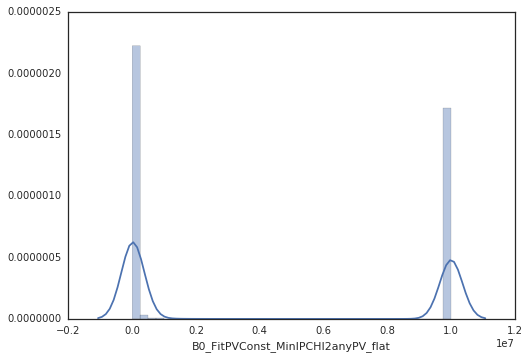

In [33]:
import seaborn as sns
sns.distplot(signal_dataframe_wrongPV['B0_FitPVConst_MinIPCHI2anyPV_flat'])

## Check correlations

In [ ]:
signal_dataframe_wrongPV

In [17]:
signal_dataframe_wrongPV.B0_FitPVConst_MinIPCHI2anyPV_flat.min()

0.00028997057

In [46]:
import seaborn as sns; sns.set_style('white')

test = signal_dataframe_wrongPV.sample(50000)
'''
x_lim = (0,10000)
y_lim = (0.003,0.015)
g = sns.jointplot(x='B0_FitPVConst_MinIPCHI2anyPV_flat', y='B0_FitPVConst_tau_flat',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")
g#g.savefig("/home/chasenberg/plots/wrong_pv/deltatau_vs_pvzpull.pdf")
print(test.shape)'''

'\nx_lim = (0,10000)\ny_lim = (0.003,0.015)\ng = sns.jointplot(x=\'B0_FitPVConst_MinIPCHI2anyPV_flat\', y=\'B0_FitPVConst_tau_flat\',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")\ng#g.savefig("/home/chasenberg/plots/wrong_pv/deltatau_vs_pvzpull.pdf")\nprint(test.shape)'

In [47]:
variables = [
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'B0_FitPVConst_tau_flat',
            'BDTresponse_wrongPV'
            ]

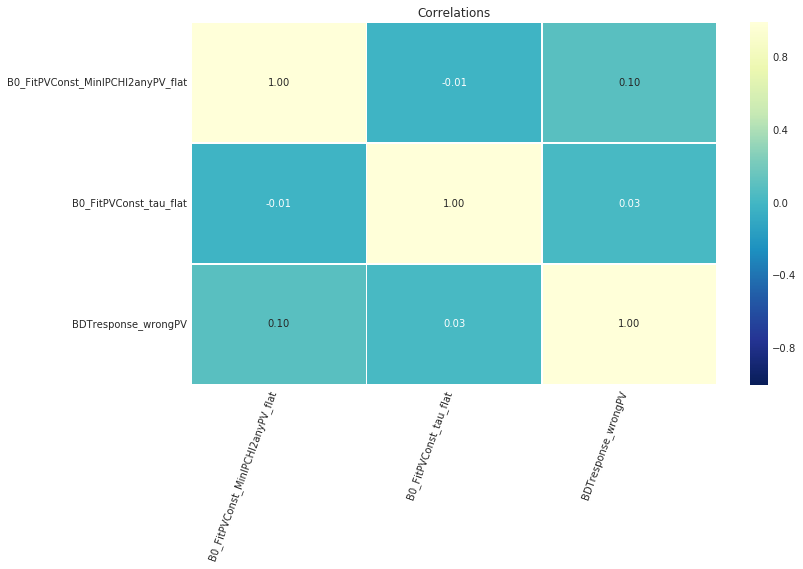

In [48]:
sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

plt.figure(figsize=(12,8))
plot_correlations(test.query('idxPV==0')[variables], annot=True, fmt='.2f')
#plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))

In [22]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d  = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = test.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

TypeError: corr() missing 1 required positional argument: 'other'

### Function to calculate the FOMs

### Configure  and define cuts 

In [8]:

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

bdt_type = 'BDTresponse_wrongPV' 
minipchi2_type = 'B0_FitPVConst_MinIPCHI2anyPV_flat'

minimum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].min()
maximum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()
iterations = 40
cuts_bdt = np.linspace(3.5,3.9,iterations) #(0,20,10)    #(0,0.001,10)
cuts_minipchi2 = np.linspace(0,85,iterations) 

cut_to_performance = {} 




### Calculate FOM

In [9]:
def calculate_foms(data_cut_bdt,best_pv_bdt,data_cut_minipchi2,best_pv_minipchi2,sig_yields_init): 
    import math
    import numpy as np
    #Empty dataframe
    df = pd.DataFrame()
    
    delta_m = 5065 
    S = 0.691 
   
    dilution_bdt_bestPV = 0
    dilution_bdt_random = 0
    dilution_bdt_bestPV_poisson = 0
    dilution_minipchi2_bestpv_poisson = 0
    
    dilution_bdt_random_poisson = 0
    dilution_bdt_bestpv_poisson = 0
    dilution_minipchi2_random_poisson = 0
    dilution_minipchi2_bestpv_poisson = 0
    dilution_bdt_random_poisson_test = 0
    dilution_bdt_bestpv_poisson_test = 0
    dilution_minipchi2_random_poisson_test = 0
    dilution_minipchi2_bestpv_poisson_test = 0
    
    tagomega_bdt_bestpv = np.array(best_pv_bdt['B0_TAGOMEGA_OS'])
    tag1_bdt_bestpv = np.array(best_pv_bdt['B0_TAGDECISION_OS'])
    time_bdt_bestpv = np.array(best_pv_bdt['B0_FitPVConst_tau_flat']) 
    error_bdt_bestpv = np.absolute(np.array(best_pv_bdt['Delta_TAU']))
    
    tagomega_bdt_random = np.array(data_cut_bdt['B0_TAGOMEGA_OS'])
    tag1_bdt_random = np.array(data_cut_bdt['B0_TAGDECISION_OS'])
    time_bdt_random = np.array(data_cut_bdt['B0_FitPVConst_tau_flat']) 
    error_bdt_random = np.absolute(np.array(data_cut_bdt['Delta_TAU']))
    
    #Calculate dilution for bdt + random selection
    for i in range(best_pv_bdt.shape[0]):
        signal_weight =  1 
        decaytime     =  time_bdt_bestpv[i]
        timeerror     =  error_bdt_bestpv[i]                
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
        dilution_bdt_bestPV    += timeerror_dilution*signal_weight
         
    signal_sum_bdt_bestpv = best_pv_bdt.shape[0]
    dilution_bdt_bestPV   /= signal_sum_bdt_bestpv
    dil_bdt_bestpv.append(dilution_bdt_bestPV)
    
    #Calculate efficiency for bdt approach with best PV selection
    yields_bdt_bestpv = best_pv_bdt.shape[0] 
    efficiency_bdt_bestpv = yields_bdt_bestpv / yields_initial_bestpv
    #Calculate efficiency for bdt approach with random selection
    yields_bdt_random = data_cut_bdt.shape[0]
    efficiency_bdt_random = yields_bdt_random / yields_initial_random
    
    #Calculate dilution for bdt + random selection
    for i in range(data_cut_bdt.shape[0]):
        signal_weight_random=  1 
        decaytime_bdt_random    =  time_bdt_random[i]
        timeerror_bdt_random    =  error_bdt_random[i]           
        timeerror_dilution_random= math.exp(-(delta_m*timeerror_bdt_random)**2)
        dilution_bdt_random     += timeerror_dilution_random*signal_weight_random
    
    dilution_bdt_random /= data_cut_bdt.shape[0] 
    #Normalize to relative poisson error
    bdt_random_poisson.append(np.sqrt(yields_bdt_random))
    bdt_bestpv_poisson.append(np.sqrt(yields_bdt_bestpv))    
    dilution_bdt_random_poisson_test = dilution_bdt_random * np.sqrt(yields_bdt_random)
    dilution_bdt_bestpv_poisson_test = dilution_bdt_bestPV * np.sqrt(yields_bdt_bestpv)
    dil_bdt_random_poisson.append(dilution_bdt_random_poisson)
    dil_bdt_bestpv_poisson.append(dilution_bdt_bestPV_poisson)
    #Fill the rest of the arrays
    eff_bdt_random.append(efficiency_bdt_random)
    dil_bdt_random.append(dilution_bdt_random)
    eff_bdt_bestpv.append(efficiency_bdt_bestpv)

    
    #Repeat all steps for minipchi2anypv
    dilution_minipchi2_bestpv = 0
    dilution_minipchi2_random = 0
    time_minipchi2_bestpv = np.array(best_pv_minipchi2['B0_FitPVConst_tau_flat']) 
    error_minipchi2_bestpv = np.absolute(np.array(best_pv_minipchi2['Delta_TAU']))
    
    tagomega_minipchi2_random = np.array(data_cut_minipchi2['B0_TAGOMEGA_OS'])
    tag1_minipchi2_random = np.array(data_cut_minipchi2['B0_TAGDECISION_OS'])
    time_minipchi2_random = np.array(data_cut_minipchi2['B0_FitPVConst_tau_flat']) 
    error_minipchi2_random = np.absolute(np.array(data_cut_minipchi2['Delta_TAU']))
    
    range_best_pv_minipchi2 = best_pv_minipchi2.shape[0]
    
    for i in range(range_best_pv_minipchi2):
        signal_weight =  1 
        timeerror_minipchi2_bestpv    =  error_minipchi2_bestpv[i]                
        timeerror_dilution_minipchi2_bestpv  = math.exp(-(delta_m*timeerror_minipchi2_bestpv)**2)
        dilution_minipchi2_bestpv    += timeerror_dilution_minipchi2_bestpv*signal_weight
         
    signal_sum_minipchi2_bestpv = range_best_pv_minipchi2  
    dilution_minipchi2_bestpv /= signal_sum_minipchi2_bestpv
    dil_minipchi2_bestpv.append(dilution_minipchi2_bestpv)
    
    #Calculate efficiency for minipchi2 approach with best PV selection
    yields_minipchi2_bestpv = best_pv_minipchi2.shape[0] 
    efficiency_minipchi2_bestpv = yields_minipchi2_bestpv / sig_yields_init
    
    
    for i in range(data_cut_minipchi2.shape[0]):
        signal_weight_minipchi2_random         =  1 
        timeerror_minipchi2_random    =  error_minipchi2_random[i]                   
        timeerror_dilution_minipchi2_random   =  math.exp(-(delta_m*timeerror_minipchi2_random)**2)    
        dilution_minipchi2_random     += timeerror_dilution_minipchi2_random*signal_weight_minipchi2_random
        
    dilution_minipchi2_random /= data_cut_minipchi2.shape[0] 
    #Calculate efficiency for minipchi2 approach with random selection
    yields_minipchi2_random = data_cut_minipchi2.shape[0] 
    efficiency_minipchi2_random = yields_minipchi2_random / sig_yields_init

    #Normalize to relative poisson error
    minipchi2_random_poisson.append(np.sqrt(data_cut_minipchi2.shape[0]))
    minipchi2_bestpv_poisson.append(np.sqrt(best_pv_minipchi2.shape[0] ))
    dilution_minipchi2_random_poisson_test = dilution_minipchi2_random * np.sqrt(data_cut_minipchi2.shape[0] )
    dil_minipchi2_random_poisson.append(dilution_minipchi2_random_poisson)
    dilution_minipchi2_bestpv_poisson_test = dilution_minipchi2_bestpv * np.sqrt(best_pv_minipchi2.shape[0] )
    dil_minipchi2_bestpv_poisson.append(dilution_minipchi2_bestpv_poisson)
    #Fill the rest of the arrays
    eff_minipchi2_random.append(efficiency_minipchi2_random)
    dil_minipchi2_random.append(dilution_minipchi2_random)
    eff_minipchi2_bestpv.append(efficiency_minipchi2_bestpv)
    dil_minipchi2_bestpv_poisson

    

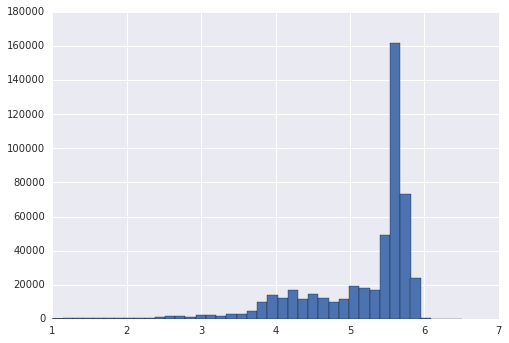

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(signal_dataframe_wrongPV['BDTresponse_wrongPV'],40,range=[1,6.5])
plt.savefig("/home/chasenberg/plots/wrong_pv/bdt_output.pdf")

In [11]:
signal_dataframe_wrongPV.shape[0]

501573

In [12]:
print(str(cuts_bdt[0]))

3.5


In [13]:

from ROOT import RooArgList
import subprocess, os
import time

sample_size = 122000
initial_cut = str(cuts_bdt[0])
signal_dataframe_wrongPV.query('BDTresponse_wrongPV>' + initial_cut).to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
print('INFO: Call CandidateSelectionGrimReaper', flush=True)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
subprocess.Popen([my_command], env=my_env, shell=True)
print("Wait for GrimReaper")
time.sleep(40.0)    # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_random = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc).sample(sample_size)
data_bestpv = signal_dataframe_wrongPV.query('idxPV==0&BDTresponse_wrongPV>' + initial_cut).sample(sample_size)

INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data


In [14]:
yields_initial_bestpv = data_bestpv.shape[0]
yields_initial_random = data_random.shape[0]

In [15]:
data_bestpv.shape[0],data_random.shape[0]

(122000, 122000)

In [16]:
eff_bdt = data_random.query('BDTresponse_wrongPV>3.9').shape[0] / data_random.shape[0]
print(eff_bdt)

0.9624918032786886


In [17]:
eff_bdt = data_random.query('B0_FitPVConst_MinIPCHI2anyPV_flat>85').shape[0] / data_random.shape[0]
print(eff_bdt)

0.9609016393442623


In [18]:
sig_yields_init = sample_size
reduced_sample = signal_dataframe_wrongPV
df = pd.DataFrame()

eff_bdt_random = []
dil_bdt_random = []
bdt_random_poisson = []
dil_bdt_random_poisson = []
eff_bdt_bestpv = []
dil_bdt_bestpv = []
bdt_bestpv_poisson = []
dil_bdt_bestpv_poisson = []
    
eff_minipchi2_random = []
dil_minipchi2_random = []
minipchi2_random_poisson = []
dil_minipchi2_random_poisson = []
eff_minipchi2_bestpv = []
dil_minipchi2_bestpv = []
minipchi2_bestpv_poisson = [] 
dil_minipchi2_bestpv_poisson = [] 

for bdt_cut,minipchi2_cut in zip(cuts_bdt,cuts_minipchi2):
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(bdt_type,bdt_cut), flush=True)
    data_cut_bdt = data_random.query('{0}>{1}'.format(bdt_type,bdt_cut))
    best_pv_bdt = data_bestpv.query('{0}>{1}'.format(bdt_type,bdt_cut))
    print('The yields of the bdt cut on random selected mc are:')
    print("---------------------------------")
    print(data_cut_bdt.shape[0])
    #MinIPCHI2 part
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(minipchi2_type,minipchi2_cut), flush=True)
    data_cut_minipchi2 = data_random.query('{0}>{1}'.format(minipchi2_type,minipchi2_cut))
    best_pv_minipchi2 = data_bestpv.query('{0}>{1}'.format(minipchi2_type,minipchi2_cut))
    print('The yields of the bestpv cut on random selected mc are:')
    print("---------------------------------")
    print(data_cut_minipchi2.shape[0])
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    foms = calculate_foms(data_cut_bdt,best_pv_bdt,data_cut_minipchi2,best_pv_minipchi2,sig_yields_init)
    print('INFO: Finish Calculation', flush=True)
    print('++++++++++++++++++++++++++')
    print('++++++++++++++++++++++++++')

INFO: Starting to test cut BDTresponse_wrongPV>3.5
The yields of the bdt cut on random selected mc are:
---------------------------------
122000
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>0.0
The yields of the bestpv cut on random selected mc are:
---------------------------------
122000
INFO: Start Calculation
INFO: Finish Calculation
++++++++++++++++++++++++++
++++++++++++++++++++++++++
INFO: Starting to test cut BDTresponse_wrongPV>3.51025641025641
The yields of the bdt cut on random selected mc are:
---------------------------------
121964
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>2.1794871794871793
The yields of the bestpv cut on random selected mc are:
---------------------------------
121980
INFO: Start Calculation
INFO: Finish Calculation
++++++++++++++++++++++++++
++++++++++++++++++++++++++
INFO: Starting to test cut BDTresponse_wrongPV>3.5205128205128204
The yields of the bdt cut on random selected mc are:
---------------------------------

In [19]:
np.amin(eff_bdt_random)

0.96249180327868855

In [20]:
#Fill the dataframe    
df_bdt = pd.DataFrame()
df_minipchi2 = pd.DataFrame()

df_bdt['efficiency_bdt_random'] = eff_bdt_random
df_bdt['dilution_bdt_random'] = dil_bdt_random #/ np.amax(dil_bdt_random)
df_bdt['efficiency_bdt_bestpv'] = eff_bdt_bestpv
df_bdt['dilution_bdt_bestPV'] = dil_bdt_bestpv  #/ np.amax(dil_bdt_bestpv)
df_bdt['bdt_random_poisson'] = bdt_random_poisson
df_bdt['bdt_bestpv_poisson'] = bdt_bestpv_poisson
df_bdt['dilution_bdt_random_poisson_test'] = df_bdt.dilution_bdt_random * df_bdt.bdt_random_poisson
df_bdt['dilution_bdt_bestpv_poisson_test'] = df_bdt.dilution_bdt_bestPV * df_bdt.bdt_bestpv_poisson


df_minipchi2['efficiency_minipchi2_random'] = eff_minipchi2_random 
df_minipchi2['dilution_minipchi2_random'] = dil_minipchi2_random #/ np.amax(dil_minipchi2_random)
df_minipchi2['efficiency_minipchi2_bestpv'] = eff_minipchi2_bestpv
df_minipchi2['dilution_minipchi2_bestPV'] = dil_minipchi2_bestpv # / np.amax(dil_minipchi2_bestpv)
df_minipchi2['minipchi2_random_poisson'] = minipchi2_random_poisson
df_minipchi2['minipchi2_bestpv_poisson'] = minipchi2_bestpv_poisson
df_minipchi2['dilution_minipchi2_random_poisson_test'] = df_minipchi2.dilution_minipchi2_random * df_minipchi2.minipchi2_random_poisson
df_minipchi2['dilution_minipchi2_bestpv_poisson_test'] = df_minipchi2.dilution_minipchi2_bestPV * df_minipchi2.minipchi2_bestpv_poisson


In [21]:
dilution_bdt_random_poisson = []
dilution_bdt_bestpv_poisson = []
dilution_minipchi2_random_poisson = []
dilution_minipchi2_bestpv_poisson = []

for i in range(df_bdt.shape[0]):
    a1 = df_bdt['dilution_bdt_random'][i] * df_bdt['bdt_random_poisson'][i]
    dilution_bdt_random_poisson.append(a1)
    a2 = df_bdt['dilution_bdt_bestPV'][i] * df_bdt['bdt_bestpv_poisson'][i]
    dilution_bdt_bestpv_poisson.append(a2)

for i in range(df_minipchi2.shape[0]):
    a3 = df_minipchi2['dilution_minipchi2_random'][i] * df_minipchi2['minipchi2_random_poisson'][i]
    dilution_minipchi2_random_poisson.append(a3)
    a4 = df_minipchi2['dilution_minipchi2_bestPV'][i] * df_minipchi2['minipchi2_bestpv_poisson'][i]
    dilution_minipchi2_bestpv_poisson.append(a4)
    
df_bdt['dilution_bdt_random_poisson']             = dilution_bdt_random_poisson
df_bdt['dilution_bdt_bestpv_poisson']             = dilution_bdt_bestpv_poisson
df_minipchi2['dilution_minipchi2_random_poisson'] = dilution_minipchi2_random_poisson
df_minipchi2['dilution_minipchi2_bestpv_poisson'] = dilution_minipchi2_bestpv_poisson


In [45]:
df_all = pd.concat([df_bdt,df_minipchi2])

In [23]:
params_bdt = list(df_bdt.columns)
params_minipchi2 = list(df_minipchi2.columns)
for param in params_bdt:
    param = str(param)
    df_bdt[param] = df_bdt[param] / df_bdt[param].max()
for param in params_minipchi2:
    param = str(param)
    df_minipchi2[param] = df_minipchi2[param] / df_minipchi2[param].max()

In [46]:
params_all = list(df_all.columns)
for param in params_all:
    param = str(param)
    df_all[param] = df_all[param] / df_all[param].max()

In [24]:
if df_minipchi2['efficiency_minipchi2_random'].min() > df_bdt['efficiency_bdt_random'].min():
    min_eff = str(df_minipchi2['efficiency_minipchi2_random'].min())
else:
    min_eff = str(df_bdt['efficiency_bdt_random'].min())
    
df_bdt_cut = df_bdt.query('efficiency_bdt_random>0.98')# + min_eff)
df_minipchi2_cut = df_minipchi2.query('efficiency_minipchi2_random>0.98')# + min_eff)

# Plot FOMs

## Compare BDT cut to MinIPCHI2 cut with random selected events each

In [25]:
df_minipchi2['efficiency_minipchi2_random'].max(),df_minipchi2['efficiency_minipchi2_random'].min()

(1.0, 0.96090163934426231)

In [26]:
df_minipchi2['efficiency_minipchi2_bestpv'].max(),df_minipchi2['efficiency_minipchi2_bestpv'].min()

(1.0, 0.96029508196721314)

In [27]:
df_bdt['efficiency_bdt_bestpv'].max(),df_bdt['efficiency_bdt_bestpv'].min()

(1.0, 0.98240163934426228)

In [28]:
df_bdt['efficiency_bdt_random'].max(),df_bdt['efficiency_bdt_random'].min()

(1.0, 0.96249180327868855)

In [29]:
df_bdt['dilution_bdt_random_poisson'].max(),df_bdt['dilution_bdt_random_poisson'].min()

(1.0, 0.98150704795708277)

In [30]:
df_bdt['bdt_random_poisson'].max(),df_bdt['bdt_random_poisson'].min()

(1.0, 0.98106666607253978)

In [31]:
df_bdt['dilution_bdt_random'].max(),df_bdt['dilution_bdt_random'].min()

(1.0, 0.99955132071088082)

### Compare BDT approach vs. MinIPCHI2 for the random PV selection

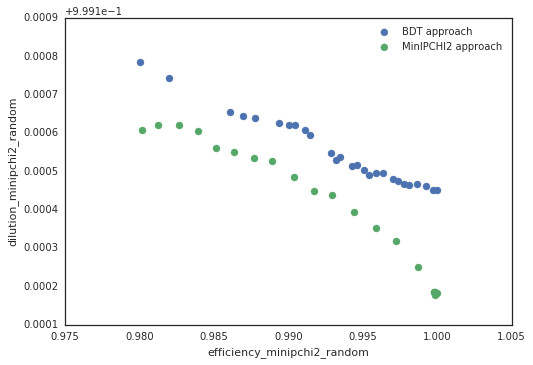

In [32]:
import seaborn as sns; sns.set_style('white')
plt.title("")
plt.xlabel("")
plt.ylabel("")

plot_1 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random',data=df_bdt_cut,x_estimator=np.mean,fit_reg=False,label="BDT approach") 
plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random',data=df_minipchi2_cut,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach")
plot_1.legend(loc="best")
#plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random.pdf")

### Normalize the dilution with poisson error

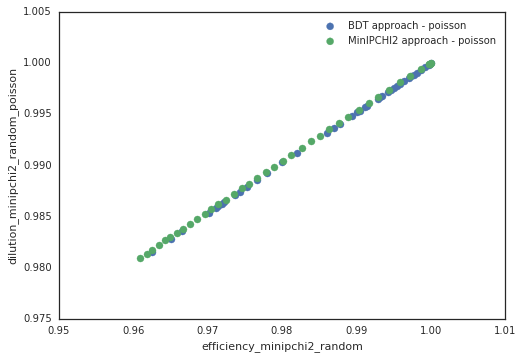

In [51]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plot_1 = sns.regplot(x='Efficiency', y='TimeresPower',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach") 
#plot_2 = sns.regplot(x='Efficiency', y='error',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")
plot_3 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random_poisson',data=df_all,x_estimator=np.mean,fit_reg=False,label="BDT approach - poisson") 
plot_2 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random_poisson',data=df_all,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach - poisson")
#plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='minipchi2_random_poisson',data=df_minipchi2_cut,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach")
plot_2.legend(loc="best")
#plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random_poisson.pdf")

### Compare BDT approach vs. MinIPCHI2 for the best PV selection

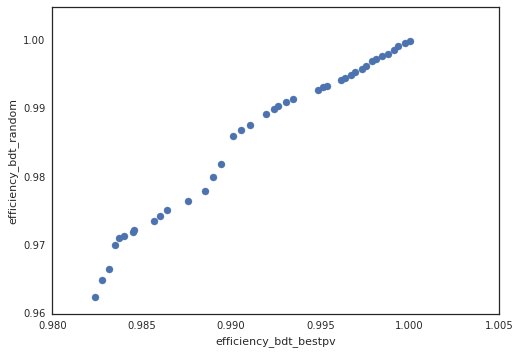

In [55]:
import seaborn as sns; sns.set_style('white')
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plot_1 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_bestPV',data=df_bdt_cut,x_estimator=np.mean,fit_reg=False,label="BDT approach") 
plot_3 = sns.regplot(x='efficiency_bdt_bestpv', y='efficiency_bdt_random',data=df_all,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach")
plot_1.legend(loc="best")
#plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random.pdf")

### Normalize dilution with poisson error

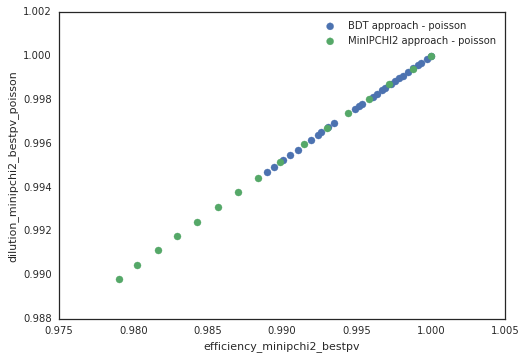

In [44]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plot_1 = sns.regplot(x='Efficiency', y='TimeresPower',data=test_cut,x_estimator=np.mean,fit_reg=True,label="BDT approach") 
#plot_2 = sns.regplot(x='Efficiency', y='error',data=test_cut,x_estimator=np.mean,fit_reg=True,label="Poisson error")
plot_3 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_bestpv_poisson',data=df_bdt_cut,x_estimator=np.mean,fit_reg=False,label="BDT approach - poisson") 
plot_2 = sns.regplot(x='efficiency_minipchi2_bestpv', y='dilution_minipchi2_bestpv_poisson',data=df_minipchi2_cut,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach - poisson")
#plot_3 = sns.regplot(x='efficiency_minipchi2_random', y='minipchi2_random_poisson',data=df_minipchi2_cut,x_estimator=np.mean,fit_reg=False,label="MinIPCHI2 approach")
plot_2.legend(loc="best")
#plt.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_bdt_random_poisson.pdf")

### Compare random selection vs best PV selection for the BDT approach

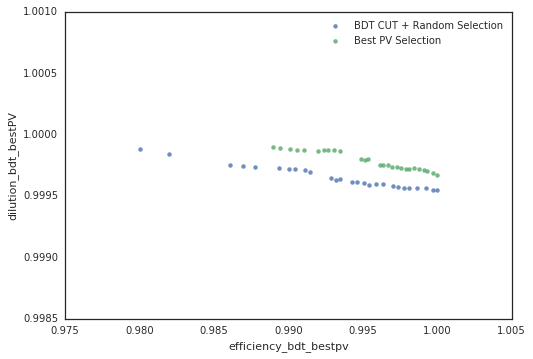

In [36]:
plot_1 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random',data=df_bdt_cut, fit_reg=False,label='BDT CUT + Random Selection')
plot_2 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_bestPV',data=df_bdt_cut, fit_reg=False,label='Best PV Selection')
plot_1.legend(loc="best")
#plot_1.set(xlim=(df['eff_bdt_random'].min(), df['eff_bdt_random'].max()))
#plot_1.set(ylim=(0.99,1.0001))
#plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_bdt_vs_bestpv.pdf")

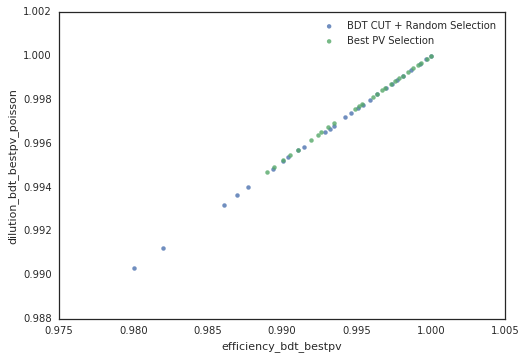

In [37]:

plot_1 = sns.regplot(x='efficiency_bdt_random', y='dilution_bdt_random_poisson',data=df_bdt_cut, fit_reg=False,label='BDT CUT + Random Selection')
plot_2 = sns.regplot(x='efficiency_bdt_bestpv', y='dilution_bdt_bestpv_poisson',data=df_bdt_cut, fit_reg=False,label='Best PV Selection')
plot_1.legend(loc="best")
#plot_1.set(xlim=(df['eff_bdt_random'].min(), df['eff_bdt_random'].max()))
#plot_1.set(ylim=(0.99,1.0001))
#plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_bdt_vs_bestpv.pdf")

### Compare random selection vs best PV selection for the MinIPCHI2 approach

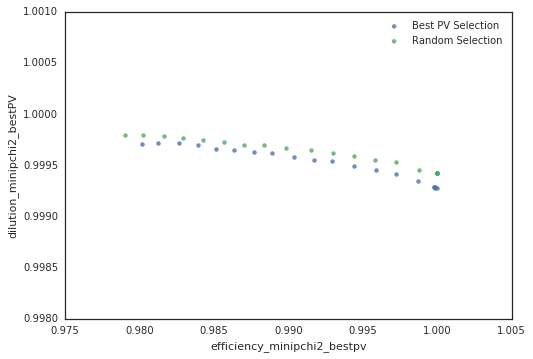

In [38]:
plot_1 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random',data=df_minipchi2_cut, fit_reg=False,label='Best PV Selection')
plot_2 = sns.regplot(x='efficiency_minipchi2_bestpv', y='dilution_minipchi2_bestPV',data=df_minipchi2_cut, fit_reg=False,label='Random Selection')
plot_1.legend(loc="best")
#plot_1.set(xlim=(df['eff_bdt_random'].min(), df['eff_bdt_random'].max()))
#plot_1.set(ylim=(0.99,1.0001))
#plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_bdt_vs_bestpv.pdf")

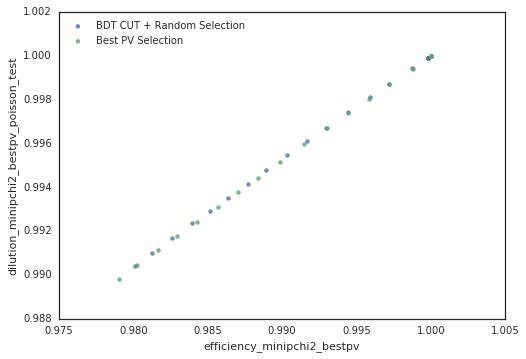

In [39]:

plot_1 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random_poisson_test',data=df_minipchi2_cut, fit_reg=False,label='BDT CUT + Random Selection')
plot_2 = sns.regplot(x='efficiency_minipchi2_bestpv', y='dilution_minipchi2_bestpv_poisson_test',data=df_minipchi2_cut, fit_reg=False,label='Best PV Selection')
plot_1.legend(loc="upper left")
#plot_1.set(xlim=(df['eff_bdt_random'].min(), df['eff_bdt_random'].max()))
#plot_1.set(ylim=(0.99,1.0001))
#plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_bdt_vs_bestpv.pdf")